In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
cd gdrive/MyDrive/Colab Notebooks/Dental_dataset/Adult tooth segmentation dataset/Panoramic radiography database

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from keras import layers, models
import pathlib
import natsort
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

In [ ]:
epochs = 7000
batch = 16
eta = 0.001
weight_decay = 6e-8
imageShape = (224, 224, 1)
maskShape = (224, 224, 1)

In [ ]:
class readDataset:
    def __init__(self, imagesPathes, masksPathes):
        self.imagesPathes = imagesPathes
        self.masksPathes = masksPathes
    def readPathes(self,):
      self.images = natsort.natsorted(list(pathlib.Path(self.imagesPathes).glob('*.*')))
      self.masks = natsort.natsorted(list(pathlib.Path(self.masksPathes).glob('*.*')))
    def readImages(self, data, typeData):
        images = []
        for img in data:
            img = cv2.imread(str(img), 0)
            img = img/255
            img = cv2.resize(img, (224, 224))
            if typeData == 'm':
                img = np.where(img > 0, 1, 0)
            images.append(img)
        return np.array(images)
    def dataAugmentation(self, images, masks):
        imagesupdate = []
        masksupdate = []
        for image, mask in zip(images, masks):
          for aug in range(2):
            imageup = image
            maskup = mask
            if aug == 0:
              imageup = image
              maskup = mask
            else:
              imageup = tf.image.flip_left_right(imageup)
              maskup = tf.image.flip_left_right(maskup)
            imagesupdate.append(imageup), masksupdate.append(maskup)
        return np.array(imagesupdate), np.array(masksupdate)

In [ ]:
datasetObject = readDataset('./images',
                            './mask')
datasetObject.readPathes()

In [ ]:
len(datasetObject.images), len(datasetObject.masks)

(598, 598)

In [ ]:
images = datasetObject.readImages(datasetObject.images, 'i')
masks = datasetObject.readImages(datasetObject.masks, 'm')
images.shape, masks.shape

((598, 224, 224), (598, 224, 224))

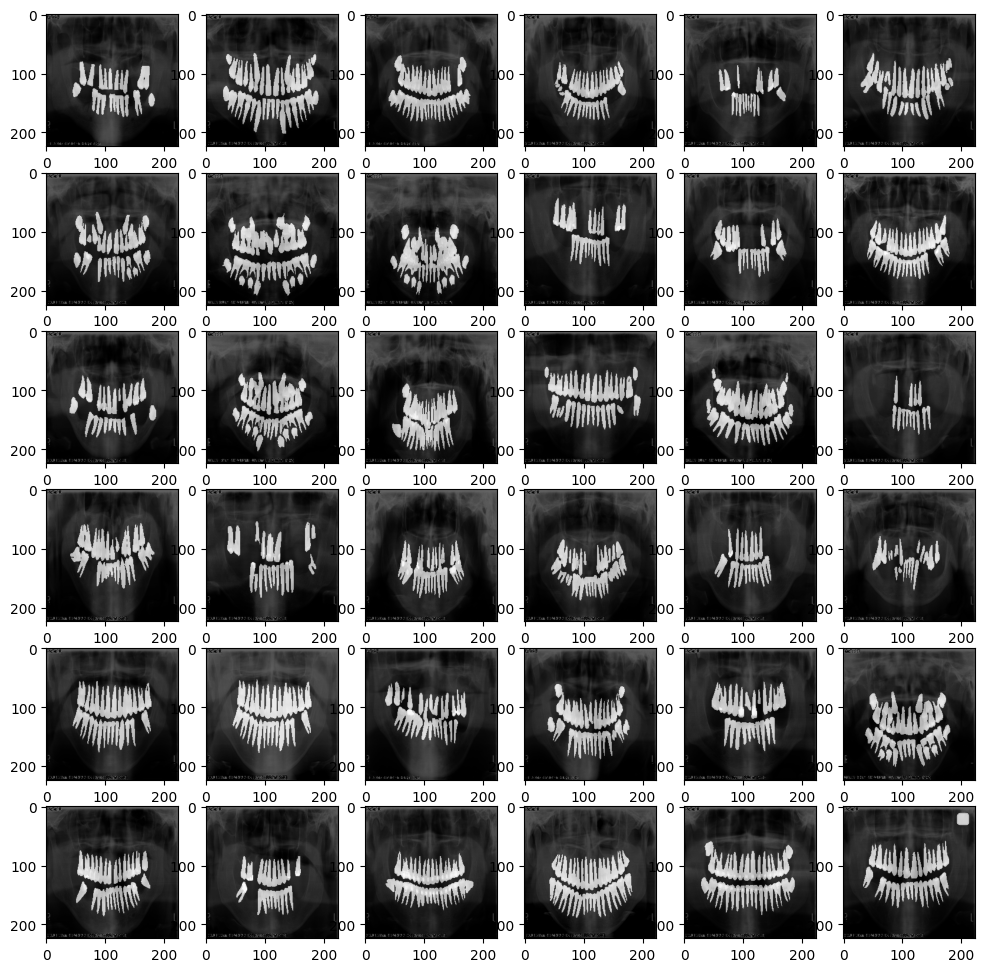

In [ ]:
plt.figure(figsize = (12, 12))
for i in range(36):
    plt.subplot(6, 6, (i + 1))
    plt.imshow(images[i], cmap = 'gray')
    plt.imshow(masks[i], alpha = 0.6, cmap = 'gray')
plt.legend()

In [ ]:
np.unique(masks), np.min(masks), np.max(masks), np.min(images), np.max(masks)

(array([0, 1]), 0, 1, 0.0, 1)

In [ ]:
x = layers.Input(shape = (224, 224, 1))
y = layers.Input(shape = (224, 224, 1))
z = layers.multiply([x, y])
m = models.Model(inputs = [x, y], outputs = z)
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply (Multiply)         (None, 224, 224, 1)          0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte

In [ ]:
imagesByMasks = m([images[:64], masks[:64]])
imagesByMasks.shape

TensorShape([64, 224, 224, 1])

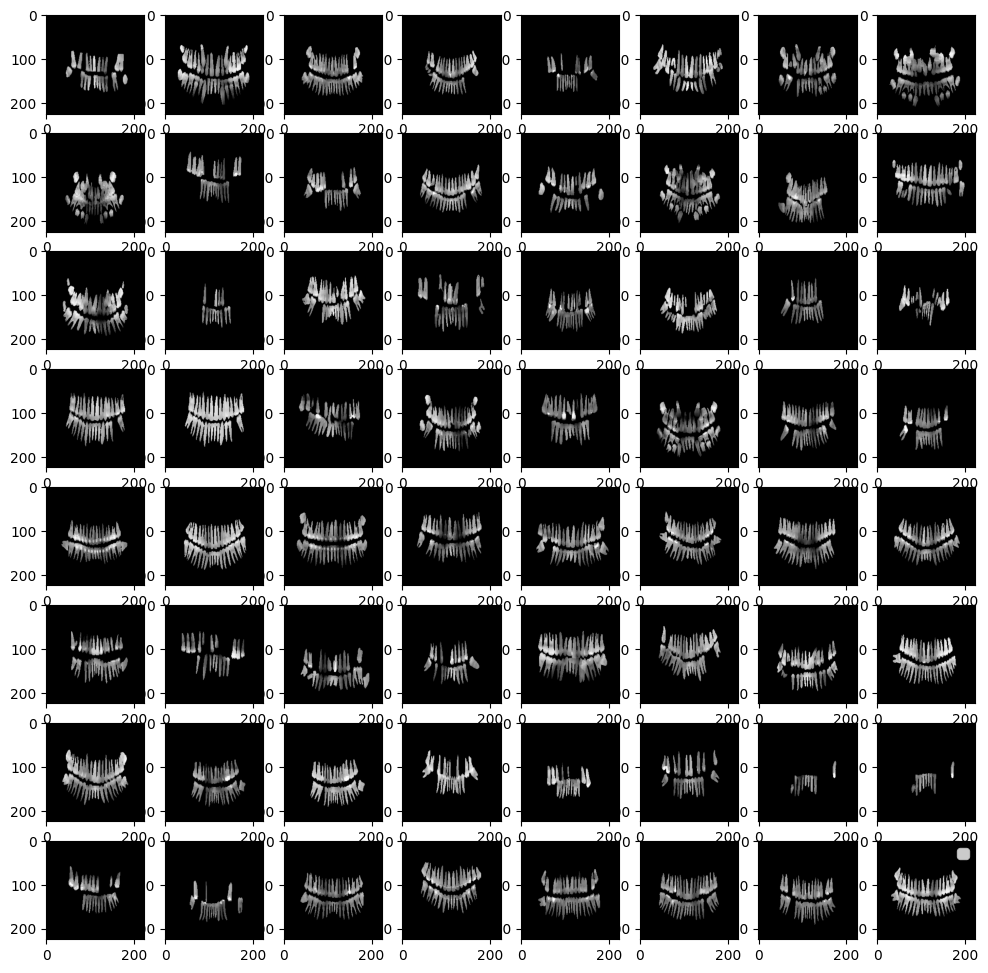

In [ ]:
plt.figure(figsize = (12, 12))
for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(imagesByMasks[i], cmap = 'gray')
plt.legend()

In [ ]:
i = 80
validImages = images[:i]
validMasks = masks[:i]
trainImages = images[i:]
trainMasks = masks[i:]
validImages.shape, validMasks.shape, trainImages.shape, trainMasks.shape

((80, 224, 224), (80, 224, 224), (518, 224, 224), (518, 224, 224))

In [ ]:
def convolution(inputs, filter, padding, strides, kernel, activation, conv_type):
  x = inputs
  x = layers.Conv2D(filter, kernel_size = kernel, padding = padding,
                    strides = strides)(x)
  x = layers.GroupNormalization(groups = filter)(x)
  if conv_type == 'decoder':
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter*2, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter*2)(x)
      x = layers.Activation(activation)(x)
      x = layers.Conv2D(filter, kernel_size = kernel, padding = padding, strides = strides)(x)
      x = layers.GroupNormalization(groups = filter)(x)
  x = layers.average([x, layers.Conv2D(filter, kernel_size = 1, padding = 'same',
                                      strides = 1)(inputs)])
  x = layers.Activation(activation)(x)
  return x

In [ ]:
def encoder(input, filter, padding, strides, kernel, activation):
  x = input
  x = convolution(x, filter, padding, strides, kernel, activation, 'encoder')
  downsample = layers.AveragePooling2D(pool_size=(2,2))(x)
  return downsample, x

In [ ]:
def decoder(input, filter, skip, padding, strides, kernel, activation):
  x = input
  x = layers.Conv2DTranspose(filter, kernel_size = kernel, padding = padding,
                             strides = 2, activation = activation)(x)
  x = layers.average([x, skip])
  x = convolution(x, filter, padding, strides, kernel, activation, 'decoder')
  return x

In [ ]:
from keras.layers import LeakyReLU

def generator(input, filter, padding, strides, kernel, weights):
  x = input
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  deco = decoder(con5, filter*16, skip5, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco1 = decoder(deco, filter*8, skip4, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco2 = decoder(deco1, filter*4, skip3, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco3 = decoder(deco2, filter*2, skip2, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  deco4 = decoder(deco3, filter, skip1, padding = padding, strides = strides,
                  kernel = kernel, activation = 'relu')
  output = layers.Conv2DTranspose(1, kernel_size = kernel, strides = strides,
                                  padding = padding, activation = 'sigmoid')(deco4)
  generator = models.Model(inputs = input, outputs = output, name = 'generator')
  if weights != None:
    generator.load_weights('./mask_generator.weights.h5')
  generator.summary()
  return generator

In [ ]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = None)

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         320       ['input_3[0][0]']             
                                                                                                  
 group_normalization (Group  (None, 224, 224, 32)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         64        ['input_3[0][0]']     

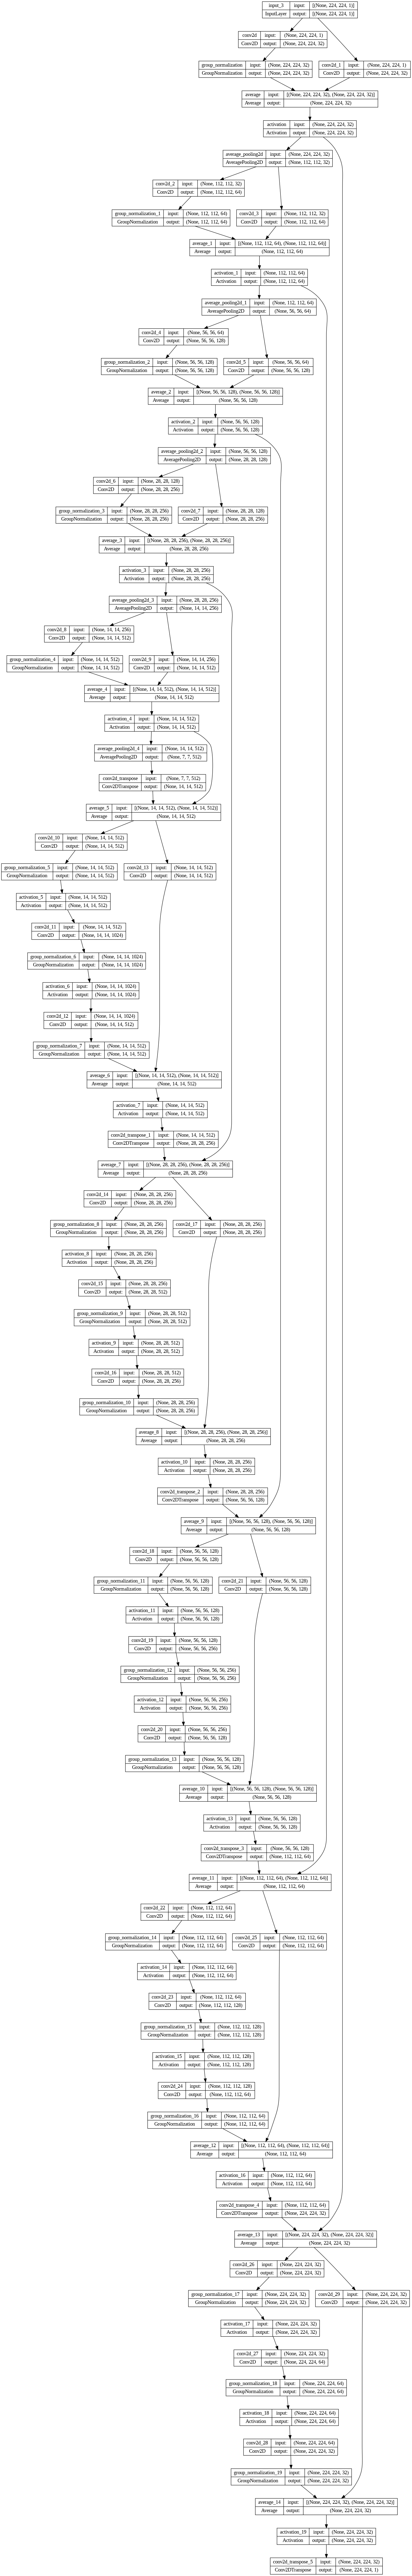

In [ ]:
tf.keras.utils.plot_model(G, show_shapes = True)

In [ ]:
def discriminator(ImageInput, maskInput, filter, padding, strides, kernel, weights,
                  lossFn, learning_rate, weight_decay):
  x = layers.multiply([ImageInput, maskInput])
  con1, skip1 = encoder(x, filter, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con2, skip2 = encoder(con1, filter*2, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con3, skip3 = encoder(con2, filter*4, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con4, skip4 = encoder(con3, filter*8, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  con5, skip5 = encoder(con4, filter*16, padding = padding, strides = strides,
                        kernel = kernel, activation = LeakyReLU())
  x = layers.GlobalAveragePooling2D()(con5)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(1)(x)
  discriminator = models.Model(inputs = [maskInput, ImageInput], outputs = x,
                              name = './discriminator.weights.h5')
  if weights != None:
    discriminator.load_weights('./discriminator.h5')
  discriminator.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate,
                                                                              weight_decay = weight_decay))
  discriminator.summary()
  return discriminator

In [ ]:
D = discriminator(ImageInput = layers.Input(shape = imageShape), maskInput = layers.Input(shape = maskShape),
                  filter = 32, padding = 'same', strides = 1, kernel = 3, weights = None,
                  lossFn = 'mse', learning_rate = eta, weight_decay = weight_decay)

Model: "./discriminator.weights.h5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 input_5 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 multiply_1 (Multiply)       (None, 224, 224, 1)          0         ['input_4[0][0]',             
                                                                     'input_5[0][0]']             
                                                                                                  
 conv2d_30 (Conv2D)          (None, 224, 224, 32)         320       ['mul

In [ ]:
!pip3 install pydot


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


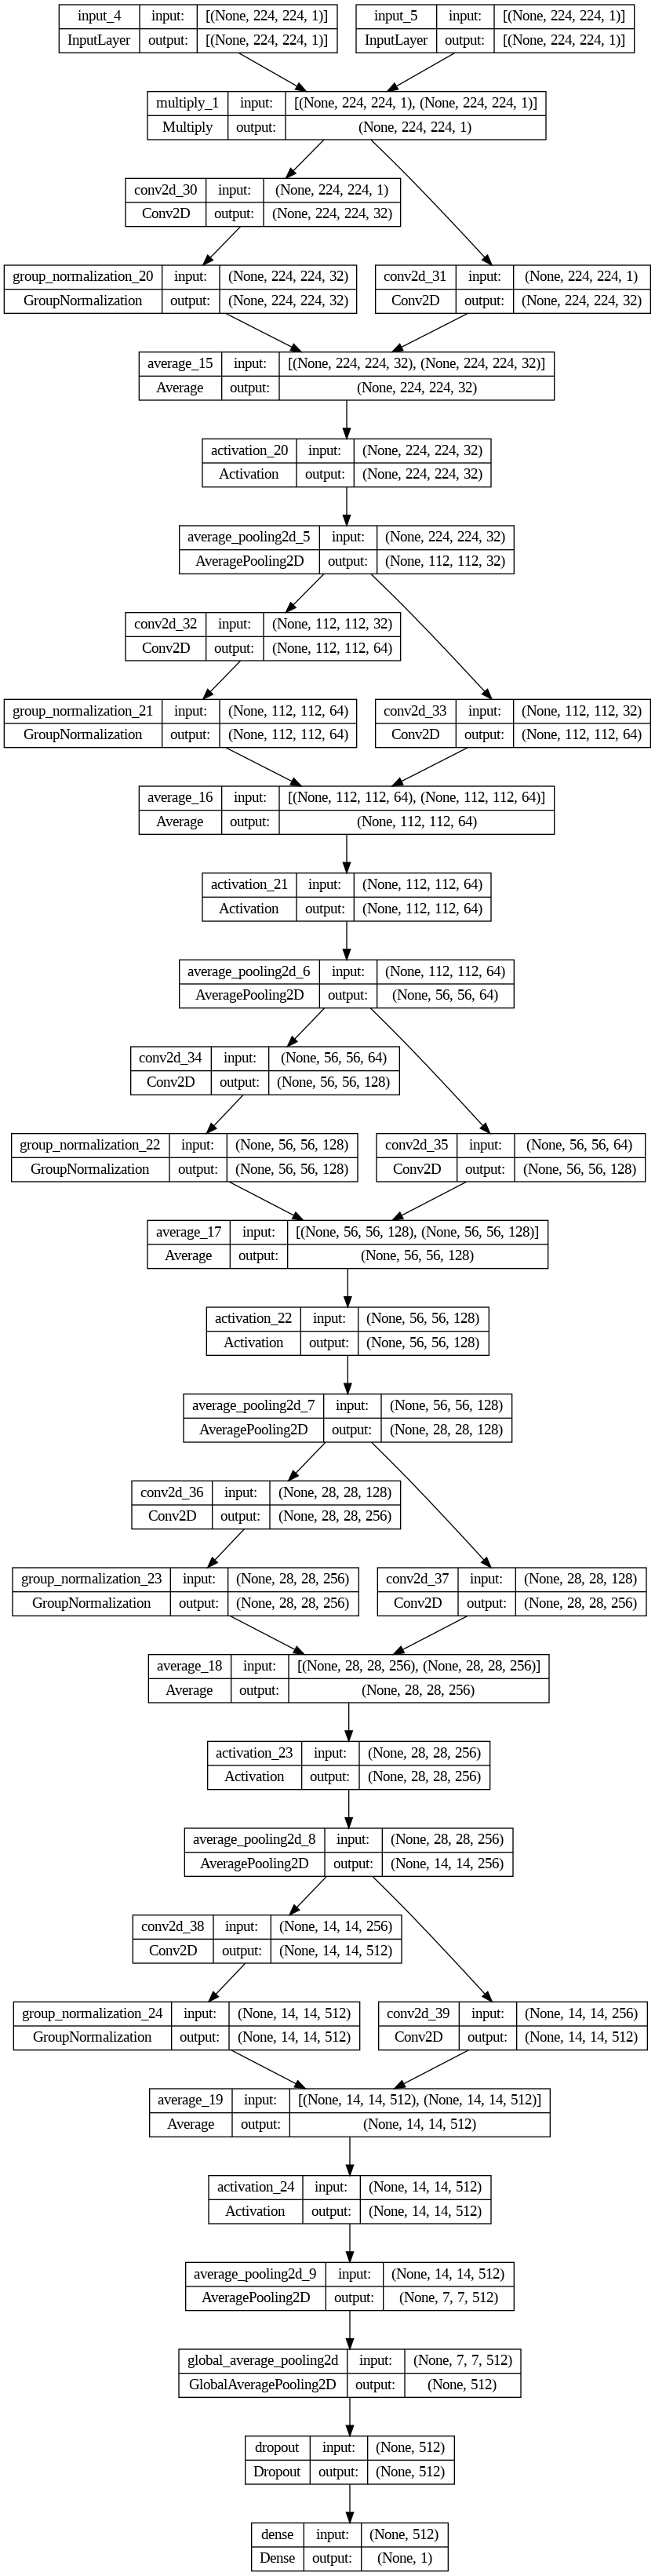

In [ ]:
tf.keras.utils.plot_model(D, show_shapes = True)

In [ ]:
def GAN(discriminator, generator, imageInput, maskInput, learning_rate, weight_decay,
                   lossFn):
  discriminator.trainable = False
  gan = models.Model(
      inputs = [imageInput],
      outputs = discriminator([generator(imageInput), imageInput],),
      name = 'gan'
  )
  gan.compile(loss = lossFn, optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate*0.5,
                                                                              weight_decay = weight_decay*0.5))
  gan.summary()
  return gan

In [ ]:
gan = GAN(discriminator = D, generator = G, imageInput = layers.Input(shape = imageShape),
          maskInput = layers.Input(shape = maskShape), learning_rate = eta, weight_decay = weight_decay,
                   lossFn = 'mse')

Model: "gan"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 generator (Functional)      (None, 224, 224, 1)          2174774   ['input_6[0][0]']             
                                                          5                                       
                                                                                                  
 ./discriminator.weights.h5  (None, 1)                    1745601   ['generator[0][0]',           
  (Functional)                                                       'input_6[0][0]']             
                                                                                                

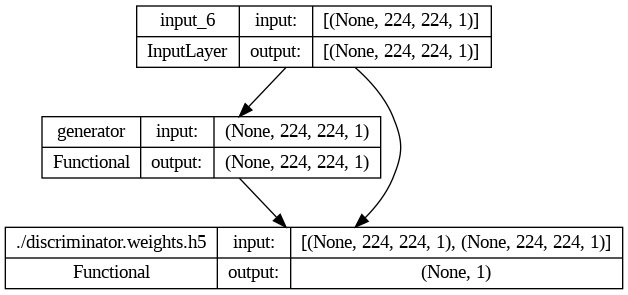

In [ ]:
tf.keras.utils.plot_model(gan, show_shapes = True)

In [ ]:
def samples(generator, images, realMasks):
  masks = tf.squeeze(generator.predict(images))
  all = np.vstack([realMasks, masks])
  plt.figure(figsize = (12, 4))
  for i in range(16):
    plt.subplot(2, 8, (i + 1))
    plt.imshow(all[i], cmap = 'gray')
  plt.show()

In [ ]:
for epoch in range(epochs):
    indexs = np.random.randint(0, len(trainImages), size = (batch, ))
    realImages = trainImages[indexs]
    realMasks = trainMasks[indexs]
    realTag = tf.ones(shape = (batch, ))
    fakeMasks = tf.squeeze(G.predict([realImages], verbose = 0))
    fakeTag = tf.zeros(shape = (batch, ))
    allMasks = np.vstack([realMasks, fakeMasks])
    allTags = np.hstack([realTag, fakeTag])
    allImages = np.vstack([realImages, realImages])
    dlossTag = D.train_on_batch([allMasks, allImages], [allTags])
    glossTag = gan.train_on_batch([realImages], [realTag,])
    print('Epoch/Epochs: {}/{}'.format(epoch, epochs))
    if epoch % 50 == 0:
        print('discriminator loss: [tag: {},], generator loss: [tag: {},]'.format(dlossTag, glossTag))
        validIndexs = np.random.randint(0, len(validImages), size = (8, ))
        samples(G, validImages[validIndexs], validMasks[validIndexs])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
G.save_weights('./mask_generator.weights.h5')
D.save_weights('./mask_discriminator.weights.h5')

In [ ]:
G = generator(input = layers.Input(shape = (224, 224, 1)), filter = 32,
              padding = 'same', kernel = 3, strides = 1, weights = True)
for layer in G.layers[:20]:
  layer.trainable = False
G.compile(loss = tf.keras.losses.BinaryFocalCrossentropy(),
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
                  metrics = ['accuracy', tf.keras.metrics.Precision(name = 'precision'),
                             tf.keras.metrics.Recall(name = 'recall')])
G.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 224, 224, 32)         320       ['input_8[0][0]']             
                                                                                                  
 group_normalization_25 (Gr  (None, 224, 224, 32)         64        ['conv2d_40[0][0]']           
 oupNormalization)                                                                                
                                                                                                  
 conv2d_41 (Conv2D)          (None, 224, 224, 32)         64        ['input_8[0][0]']     

In [ ]:
G.evaluate(validImages, validMasks)

3/3 [==============================] - 20s 383ms/step - loss: 0.3189 - accuracy: 0.9763 - precision: 0.9128 - recall: 0.8760


[0.3189416229724884,
 0.9762815237045288,
 0.9127908945083618,
 0.8759583830833435]

In [ ]:
G.evaluate(trainImages, trainMasks)

17/17 [==============================] - 12s 724ms/step - loss: 0.2941 - accuracy: 0.9779 - precision: 0.9142 - recall: 0.8915


[0.29411181807518005,
 0.9779054522514343,
 0.9142014980316162,
 0.8914826512336731]

In [ ]:
history = G.fit(trainImages, trainMasks, epochs = 160, batch_size = 8,
                        validation_data = (validImages, validMasks), callbacks = [
                            tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss',
                                                             mode = 'min',
                                                             restore_best_weights = True)
                        ])


Epoch 1/160
65/65 [==============================] - 59s 466ms/step - loss: 0.2608 - accuracy: 0.9795 - precision: 0.9176 - recall: 0.9025 - val_loss: 0.2503 - val_accuracy: 0.9790 - val_precision: 0.9168 - val_recall: 0.8976
Epoch 2/160
65/65 [==============================] - 21s 327ms/step - loss: 0.2042 - accuracy: 0.9801 - precision: 0.9173 - recall: 0.9088 - val_loss: 0.1843 - val_accuracy: 0.9779 - val_precision: 0.9084 - val_recall: 0.8964
Epoch 3/160
65/65 [==============================] - 22s 345ms/step - loss: 0.1375 - accuracy: 0.9775 - precision: 0.8994 - recall: 0.9058 - val_loss: 0.1186 - val_accuracy: 0.9752 - val_precision: 0.8814 - val_recall: 0.9044
Epoch 4/160
65/65 [==============================] - 22s 346ms/step - loss: 0.0878 - accuracy: 0.9744 - precision: 0.8661 - recall: 0.9190 - val_loss: 0.0803 - val_accuracy: 0.9722 - val_precision: 0.8497 - val_recall: 0.9190
Epoch 5/160
65/65 [==============================] - 21s 328ms/step - loss: 0.0609 - accuracy: 0

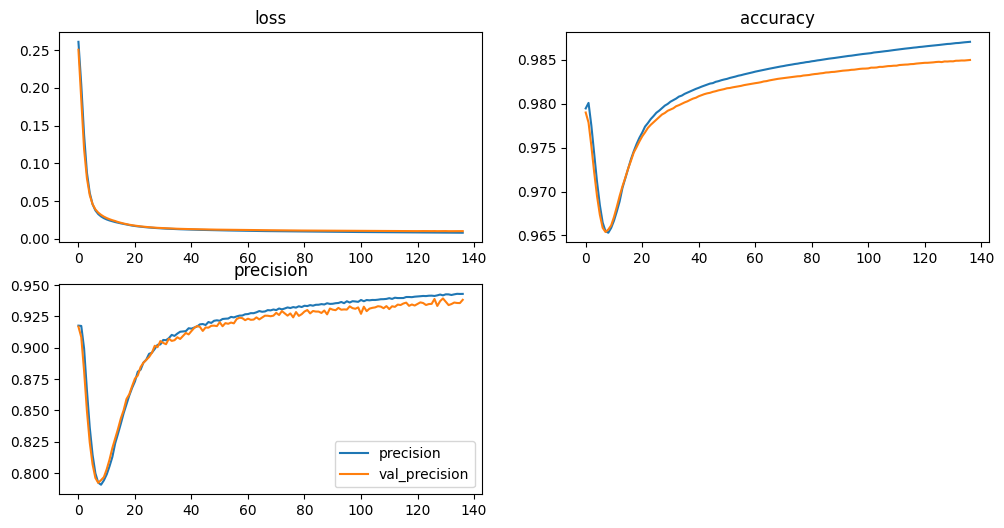

In [ ]:
metrics = ['loss','accuracy', 'precision']
plt.figure(figsize = (12, 6))
for i in range(3):
    plt.subplot(2, 2, (i + 1))
    plt.plot(history.history['{}'.format(metrics[i])], label = '{}'.format(metrics[i]))
    plt.plot(history.history['val_{}'.format(metrics[i])], label = 'val_{}'.format(metrics[i]))
    plt.title('{}'.format(metrics[i]))
plt.legend()

In [ ]:
G.evaluate(validImages, validMasks)

3/3 [==============================] - 1s 355ms/step - loss: 0.0103 - accuracy: 0.9849 - precision: 0.9340 - recall: 0.9338


[0.010265892371535301,
 0.9849033951759338,
 0.9339897632598877,
 0.9337758421897888]

In [ ]:
G.evaluate(trainImages, trainMasks)

17/17 [==============================] - 8s 445ms/step - loss: 0.0083 - accuracy: 0.9869 - precision: 0.9410 - recall: 0.9457


[0.008302141912281513,
 0.9869466423988342,
 0.941027045249939,
 0.9457257986068726]

In [ ]:
G.save('./final_tooth_mask_generation.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras import models
G = tf.keras.models.load_model('./final_tooth_mask_generation.h5')

In [ ]:
masks_pred = G.predict(validImages)
masks_pred = (masks_pred >= 0.5).astype('int')

3/3 [==============================] - 3s 483ms/step


In [ ]:
masks_pred.shape

(80, 224, 224, 1)

In [ ]:
def draw(images, masks, y_pred):
  plt.figure(figsize = (12, 50))
  index = -1
  n = np.random.randint(y_pred.shape[0])
  for i in range(120):
    plt.subplot(20, 6, (i + 1))
    if index == -1:
      plt.imshow(images[n], cmap = 'gray')
      plt.title('Image')
      index = 0
    elif index == 0:
      plt.imshow(images[n], cmap = 'gray')
      plt.imshow(masks[n], alpha = 0.6, cmap = 'gray')
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(images[n], cmap = 'gray')
      plt.imshow(np.reshape(y_pred[n], (224, 224)), alpha = 0.6, cmap = 'gray')
      plt.title('Predict Mask')
      index = -1
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

In [ ]:
draw(validImages, validMasks, masks_pred)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
masks_pred = G.predict(trainImages)
masks_pred = (masks_pred >= 0.5).astype('int')

17/17 [==============================] - 7s 463ms/step


In [ ]:
masks_pred.shape

(518, 224, 224, 1)

In [ ]:
draw(trainImages, trainMasks, masks_pred)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
draw(trainImages, trainMasks, masks_pred)

Output hidden; open in https://colab.research.google.com to view.